# ABCM Computer lab 3: Population effects & Cultural evolution

This notebook contains Python code for the model by Cuskley et al. (2018), which was kindly shared with me by the first author Christine Cuskley. (Note that the simulations reported in the actual paper were run using C++ code, which is the code you can find in the GitHub repository under the link on p. 757 of the paper: https://github.com/CCuskley/RuleEmergence .)

Below follows a brief walk-through of the code, with some exercises in between.

To load the code into your notebook, make sure to run each of the code cells below in turn.

## Activate your virtual environment

If you've created a virtual environment for this course before, **don't forgot to activate your virtual environment** before running this notebook. (Activate your virtual environment from the terminal, then type ```jupyter notebook``` in the terminal to open Jupyter notebooks in the browser, then open the notebook for this computer lab, and do Kernel --> Change kernel --> ```<myenv>```, where ```<myenv>``` is the name of your virtual environment.)

In [2]:
import numpy as np
from scipy.stats import entropy
from collections import Counter
import random
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.__version__

'0.12.2'

## Parameter settings:

Below are the parameter settings.

Unfortunately, the code takes a while to run (hence why Cuskley et al., 2018 ended up implementing the model in C++ instead). To make it feasible to run some simulations in a reasonable amount of time, the code below therefore makes a number of changes compared to the Cuskley et al. (2018) parameter settings. See the parameter settings below; the comment after each parameter states what setting Cuskley et al. (2018) used.

These measures should hopefully allow you to run the relevant simulations in ~20 minutes. 

Have a look at each of the parameters below, and check whether you understand which parameter or condition described in Cuskley et al. (2018) they correspond to.

In [4]:
popSizes_to_compare = [10, 50]  # small pop size first, large pop size second. Cuskley et al. (2018) used 20 for small and 100 for large pop
runs = 2  # number of independent simulation runs (int). Cuskley et al. (2018) used 100
maxTime = 2000  # number of timesteps (int). Cuskley et al. (2018) used 10,000
doReplace = True  # whether to do replacement (i.e., population turnover) or not (Boolean; True or False)
doGrowth = False  # whether to do population growth or not (Boolean; True or False)

k = 750  # token threshold for proficiency. Cuskley et al. (2018) used 1500
d = 100  # memory window, see Cuskley et al. (2017): https://doi.org/10.1016/j.cognition.2016.11.001. Cuskley et al. used 100
r = 0.001  # the rate of replacement for turnover. Cuskley et al. (2018) used 0.001.
g = 0.001  # the rate of growth. Cuskley et al. (2018) used 0.001.
lemmas = 14  # number of lemmas (int); 28 in the Cuskley et al. (2018) paper. Cuskley et al. (2018) used 28
inflections = 6  # number of inflections (int); 12 in the Cuskley et al. (2018) paper. Cuskley et al. (2018) used 12

In the code of Cuskley et al. (2018), the ```topic_list```, which determines the frequency of each of the lemmas according to a Zipfian distribution, is hardcoded (see code cell below). However, if we want to be able to change the number of lemmas in the simulation, we need a function that generates this Zipfian distribution list with the right number of lemmas. I've written a function that does that, called ```zipfian_vocab()```, below:

In [5]:
topic_list_original_code = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 12, 12, 13, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]

lemfreq_original_code = Counter(topic_list_original_code)

In [6]:
print(topic_list_original_code)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [7]:
len(topic_list_original_code)

500

In [8]:
lemfreq_original_code

Counter({0: 318,
         1: 66,
         2: 35,
         3: 21,
         4: 14,
         5: 6,
         6: 5,
         7: 4,
         8: 4,
         9: 3,
         10: 3,
         11: 3,
         12: 2,
         13: 2,
         14: 1,
         15: 1,
         16: 1,
         17: 1,
         18: 1,
         19: 1,
         20: 1,
         21: 1,
         22: 1,
         23: 1,
         24: 1,
         25: 1,
         26: 1,
         27: 1})

In [9]:
len(lemfreq_original_code)

28

In [10]:
def zipfian_vocab(n_lemmas,a, n_tokens):
    """
    Generates a vocabulary (numpy array of n_tokens tokens of n_lemmas types, with Zipfian frequency distribution)
    :param n_lemmas: int: number of lemmas
    :param a: int: exponent (parameter a) used to create Zipfian frequency distribution. Cuskley et al., 2018 used 2
    :param n_tokens: int: number of tokens in vocabulary. Cuskley et al. seem to have used 500 (in C++ implementation)
    :return: (1) numpy array containing n_tokens tokens of n_lemmas types; (2) numpy array with log frequency per lemma
    """
    lemma_indices = np.arange(n_lemmas)  # create numpy array with index for each lemma
    zipf_dist = np.random.zipf(a, size=n_lemmas)  # create Zipfian frequency distribution for lemmas
    zipf_dist_in_probs = np.divide(zipf_dist, np.sum(zipf_dist))
    zipf_dist_for_n_tokens = np.multiply(zipf_dist_in_probs, n_tokens)
    zipf_dist_for_n_tokens = np.ceil(zipf_dist_for_n_tokens)  # Round UP, so that we get *at least* n_tokens in vocab
    vocabulary = np.array([])
    for i in range(len(lemma_indices)):
        lemma_index = lemma_indices[i]
        lemma_freq = zipf_dist_for_n_tokens[i]
        vocabulary = np.concatenate((vocabulary, np.array([lemma_index for x in range(int(lemma_freq))])))
    for j in range(2):  # doing this twice because sth weird w/ np.delete() function: doesn't always delete all indices
        # (possibly to do with later index going out of bounds once previous indices have been deleted)
        if vocabulary.shape[0] > n_tokens:  # if vocab is larger than n_tokens, randomly remove excess tokens
            random_indices = np.random.choice(np.arange(vocabulary.shape[0]), size=(vocabulary.shape[0] - n_tokens))
            vocabulary = np.delete(vocabulary, random_indices)
    vocabulary = vocabulary.astype(int)
    return vocabulary


### Always re-run the code cell below after changing the lemmas parameter!

In [11]:
# 2 is what Cuskley et al. (2018) used as the exponent (parameter a) for the Zipfian distribution, and 500 is the
# length of the topic_list from the original code:

topic_list = zipfian_vocab(lemmas, 2, 500)

lemfreq = Counter(topic_list)

In [12]:
topic_list

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,
        8,  8,  8,  8,  8

In [13]:
len(topic_list)

500

In [14]:
lemfreq

Counter({0: 22,
         1: 43,
         2: 22,
         3: 44,
         4: 22,
         5: 22,
         6: 22,
         7: 22,
         8: 43,
         9: 21,
         10: 22,
         11: 22,
         12: 129,
         13: 44})

In [15]:
len(lemfreq)

14

## The Agent class:

Below is the definition of the ```Agent``` class. The main attribute that an ```Agent``` object consists of is its matrix ```self.matrix```. This matrix represents the agent's vocabulary. For each possible lemma-inflection pairing, the matrix contains 4 entries (which are all initialised at 0). By running the code cell below, you can see what an empty version of an agent's matrix looks like (i.e., before the agent has done any interactions):

In [16]:
np.zeros(shape=(lemmas,inflections), dtype = (float, 4))

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],


As is explained in the comment in the ```Agent.__init__()``` method, these 4 entries represent: ```[successes, total inters., weight (successes/total inters), last heard]```. 

That is: 

- ```self.matrix[L][I][0]``` keeps track of the number of communicative successes achieved with that particular lemma-inflection pairing.
- ```self.matrix[L][I][1]``` keeps track of the total number of interactions in which the agent has used that particular lemma-inflection pairing.
- ```self.matrix[L][I][2]``` keeps track of the _relative_ successfullness of that particular lemma-inflection pairing: i.e., the number of times it led to communicative success, divided by the total number of times it was used.
- ```self.matrix[L][I][3]``` keeps track of at which timestep this lemma-inflection pairing was last heard (this is relevant for the ```Agent.purgeLemmas()``` method which implements the memory decay that Cuskley et al., 2018 describe on page 750).

Have a look at the ```.updateInflection()``` method of the ```Agent``` class to see how these four entries inside the agent's vocabulary matrix are updated.

Then have a look at where/when the ```.updateInflection()``` method is called.

In [17]:

class Agent:
    def __init__(self,L,I):
        self.tokens=0
        self.typeGen=False
        self.isActive=False
        self.matrix = np.zeros(shape=(L,I), dtype = (float, 4))
        #the above generates L=28 Lemmas
        #the index is the identity of the lemma.
        #each Lemma has a list of 12 inflection arrays
        #the index of each inflection is its identity
        #each inflection array has 4 zeros initially,
        #standing in for:
        #[successes, total inters., weight (successes/total inters), last heard]

    
    def resetAgent(self, L,I):
        self.isActive=True
        self.tokens=0
        self.typeGen=False
        self.matrix = np.zeros(shape=(L,I), dtype = (float, 4)) 

    def resetLemma(self,L):
        for infl in self.matrix[L]:
            self.matrix[L][infl]=[0,0,0,0]

    def updateInflection(self, L,I, outcome, tstep):
        self.matrix[L][I][0]+=outcome
        self.matrix[L][I][1]+=1
        self.matrix[L][I][2]=self.matrix[L][I][0]/self.matrix[L][I][1]
        self.matrix[L][I][3]=tstep
        if self.typeGen==False:
            self.tokens+=1
            if self.tokens>k:
                self.typeGen=True

    def hasInflections(self,L):
        hasInts=False
        for i in range(inflections):
            if self.matrix[L][i][2]>0:
                hasInts=True
                break
        return hasInts

    def getBestInfl(self, L):        
        bestWeight= -0.5
        bestInfl=0
        for i in range(inflections):
            if self.matrix[L][i][2]>bestWeight:
                bestWeight=self.matrix[L][i][2]
                bestInfl=i
        if bestWeight<=0:
            return -1
        else:
            return bestInfl

    def purgeLemmas(self, tstep):
        for l in range(lemmas):
            for i in range(inflections):
                if tstep-self.matrix[l][i][3]>d:
                    self.matrix[l][i]=[0,0,0,0]

    def typeGeneralise(self):
#         maxTypes=[0,0,0,0,0,0,0,0,0,0,0,0]  # This was hard-coded in the original code
        maxTypes = [0 for x in range(inflections)]
        for l in range(lemmas):
            bestinfl=self.getBestInfl(l)
            if bestinfl>=0:
                maxTypes[bestinfl]+=1
        maxval=max(maxTypes)
        if maxval==0:
            #we dont have any best inflections, choose randomly.
#             return random.randint(0,11)  # This was hard-coded in the original code
            return random.randint(0,inflections-1)
        else:
            #break ties
            ties=[]
            for m in range(len(maxTypes)):
                if maxTypes[m]==maxval:
                    ties.append(m)
            return random.choice(ties)


    def tokenGeneralise(self):        
#         maxTokens=[0,0,0,0,0,0,0,0,0,0,0,0]  # This was hard-coded in the original code
        maxTokens = [0 for x in range(inflections)]
        for l in range(lemmas):
            for i in range(inflections):
                maxTokens[i]+=self.matrix[l][i][0]
        maxval=max(maxTokens)
        if maxval==0:
            #we dont have any best inflections, choose randomly.
#             return random.randint(0,11)  # This was hard-coded in the original code
            return random.randint(0,inflections-1)
        ties=[]
        for m in range(len(maxTokens)):
            if maxTokens[m]==maxval:
                ties.append(m)
        return random.choice(ties)

    def genInfl(self,L):
        hasInfl=self.hasInflections(L)
        if hasInfl:
            bestinfl=self.getBestInfl(L)
            if bestinfl>=0:
                return bestinfl
            else:
                hasInfl=False
        if hasInfl==False:            
            if(self.typeGen):
                return self.typeGeneralise()
            else:
                return self.tokenGeneralise()

    def hear(self,L,infl,tstep):
        if self.matrix[L][infl][1]>0:
            outcome=1
        else:
            guess=self.genInfl(L)
            if guess==infl:
                outcome=1
            else:
                outcome=0
        self.updateInflection(L,infl,outcome,tstep)
        return outcome

**Exercise 1:**

**a)** What do the L and the I in the ```Agent.__init__()``` method stand for? (Inspect the code in order to figure this out.) And what variables in the list of parameter settings above would be the right variables to give as input arguments for L and I when initialising an Agent object?

**b)** In a code cell below, create two Agent objects, and save them in variables called ```agent_a``` and ```agent_b```, respectively. Then print and inspect the vocabulary matrices of each of these two agents (see the ```__init__()``` method of the ```Agent``` class).

**Answer to exercise 1.a):**

[Your answer should start here, and, depending on the question, may consist of one or more text cells and/or code cells. You can create as many text and/or code cells as you need in order to answer the question.]

**Answer to exercise 1.b):**

[Your answer should start here, and, depending on the question, may consist of one or more text cells and/or code cells. You can create as many text and/or code cells as you need in order to answer the question.]

**Exercise 2:**

**a)** In a code cell below, write some code to have your ```agent_a``` and ```agent_b``` interact with each other for 28 rounds (i.e., twice the number of lemmas). Your code should have the following features:
- ```agent_a``` and ```agent_b``` should take turns being the speaker and the hearer.
- At each interaction, a random lemma should be selected as the 'topic' for the agents to talk about.
- After the speaker agent has produced an utterance, and the hearer agent has interpreted that utterance, both agents should update their vocabulary matrices accordingly.

In order to write this code, use the following three methods from the ```Agent``` class:

- ```Agent.genInfl()```
- ```Agent.hear()```
- ```Agent.updateInflection()```

**Tip 1:** Before you start writing your code, have a look at how these three methods are defined in the ```Agent``` class above.

**Tip 2:** Before you start writing your code, have a look at how these three methods are used in the ```doRuns()``` function below (under the heading _Running simulations_).

**Tip 3:** Inspect the ```Agent.hear()``` method carefully, to find out what is needed in order to have the two different agents update their vocabulary matrix.

**b)** After having ```agent_a``` and ```agent_b``` interact with each other for 28 timesteps, inspect how their vocabularies have changed, by printing their vocabulary matrices again. Is there a lemma-inflection pair with which ```agent_b``` has had 100% communicative success so far? And what does the entry for that lemma-inflection pair look like for ```agent_a```, compared to for ```agent_b```?

**Answer to exercise 2.a):**

[Your answer should start here, and, depending on the question, may consist of one or more text cells and/or code cells. You can create as many text and/or code cells as you need in order to answer the question.]

**Answer to exercise 2.b):**

[Your answer should start here, and, depending on the question, may consist of one or more text cells and/or code cells. You can create as many text and/or code cells as you need in order to answer the question.]

## Measuring regularity and stability:

The functions below are used to measure the regularity and the stability of the language system in the population (see section 2.1.4. _Measuring the system_ in the Cuskley et al., 2018 paper).

In [18]:
def measureRegularity(p):
#     inflcts=[0,0,0,0,0,0,0,0,0,0,0,0]  # This was hard-coded in the original code
    inflcts = [0 for x in range(inflections)]
    for i in range(inflections):
        for agnt in p:
            for lem in range(lemmas):
                if agnt.genInfl(lem)==i:
                    inflcts[i]+=1
    inflprobs=[]
    activeCt=0
    for ct in inflcts:
        inflprobs.append(ct / len(p) * lemmas)
        if ct>0:
            activeCt+=1
    return {"Hv":entropy(inflprobs),"activeCount":activeCt}

In [19]:
def measureStability(p, L):
#     inflcts=[0,0,0,0,0,0,0,0,0,0,0,0]  # This was hard-coded in the original code
    inflcts = [0 for x in range(inflections)]
    for i in range(inflections):
        for agnt in p:
            if agnt.genInfl(L)==i:
                inflcts[i]+=1
    inflprobs=[]
    for ct in inflcts:
        inflprobs.append(ct/len(p))
    return entropy(inflprobs)

In [20]:
def getRegIndex(p):
#     inflcts=[0,0,0,0,0,0,0,0,0,0,0,0]  # This was hard-coded in the original code
    inflcts = [0 for x in range(inflections)]
    for i in range(inflections):
        for agnt in p:
            for lem in range(lemmas):
                if agnt.genInfl(lem)==i:
                    inflcts[i]+=1
    inflvals=list(set(inflcts))
    inflvals.sort()
    ranks=[]
    for i in range(inflections):
        ranks.append(inflvals.index(inflcts[i]))
    return ranks.index(0)

In [21]:
def probReg(L,topInfl,p):
    tops=0
    for agnt in p:
        if agnt.genInfl(L)==topInfl:
            tops+=1
    return tops/len(p)

## Running simulations:

The ```doRuns()``` function below runs several runs of a given simulation, and saves the results of the ```measureRegularity``` function and the ```measureStability()``` function in two dictionaries (in a format that makes it easy to convert into a ```Pandas``` dataframe).

In [22]:
def doRuns(popSize, regularity_dictionary, stability_dictionary):
    for run in range(runs):
        pop=[]
        interTime=0
        for a in range(popSize):
            pop.append(Agent(lemmas, inflections))
        print("New population of ", popSize," starting agents initialised.")
        print("Starting run number ", run,  "for ",maxTime," timesteps, where one step is ",popSize," interactions...")
        for t in range(maxTime):
            #memory check at the start of a timestep
            if t>d:
                for p in pop:
                    p.purgeLemmas(t)
            #now get to interacting
            for i in range(popSize):
                s=random.randint(0,len(pop)-1)
                h=random.randint(0,len(pop)-1)
                while s==h:
                    h=random.randint(0,len(pop)-1)
                topic=random.choice(topic_list)
                if pop[s].hasInflections(topic):
                    utterance=pop[s].getBestInfl(topic)
                else:
                    utterance=pop[s].genInfl(topic)
                result=pop[h].hear(topic,utterance,t)#hearing entails update, returns result
                pop[s].updateInflection(topic,utterance,result,t)

                #REPLACEMENT AND GROWTH HERE
                if doReplace:
                    rDice=random.uniform(0,1)
                    if rDice<=r:
                        #make a random agent a baby
                        youbaby=random.randint(0,len(pop)-1)
                        pop[youbaby].resetAgent(lemmas, inflections)
                if doGrowth:
                    gDice=random.uniform(0,1)
                    if gDice<=g:
                        #add an agent
                        pop.append(Agent(lemmas, inflections))
                        
            #Recording each timestep: number of active inflections and hv
            regInfo=measureRegularity(pop)
            regularity_dictionary["Run"].append(run)
            regularity_dictionary["Timestep"].append(t)
            regularity_dictionary["InitPopSize"].append(popSize)
            regularity_dictionary["H_v"].append(regInfo["Hv"])
            regularity_dictionary["ActiveInfl"].append(regInfo["activeCount"])

        reg = getRegIndex(pop)
        for l in range(lemmas):
            stability_dictionary["Run"].append(run)
            stability_dictionary["InitPopSize"].append(popSize)
            stability_dictionary["EndPopSize"].append(len(pop))
            stability_dictionary["LemmaIndex"].append(l)
            stability_dictionary["LemmaFrequency"].append(lemfreq[l]/len(topic_list))
            stability_dictionary["H_l"].append(measureStability(pop,l))
            stability_dictionary["PropReg"].append(probReg(l,reg,pop))

    return regularity_dictionary, stability_dictionary

The code cell below defines a function called ```run_simulations()``` that can run a number of simulations (as many as specified by the ```runs``` parameter), for each population size as specified by the ```popSizes_to_compare``` parameter. The ```run_simulations()``` function calls the ```doRuns()``` function defined above.

The ```run_simulations()``` function returns to output variables: ```regularity_dataframes_combined``` and ```stability_dataframes_combined```. These are two ```pandas``` dataframes, which contain the results of the ```measureRegularity``` function and the ```measureStability()``` function, respectively.
Before returning this output, the ```run_simulations()``` function also saves those pandas dataframes as ```pickle``` files on your machine, so you don't lose your simulation results if you close this notebook. (It saves the files to the same folder that this notebook is in.)

In [23]:
def run_simulations():
    regularity_results_per_popSize = []
    stability_results_per_popSize = []
    for i in range(len(popSizes_to_compare)):

        start = time.time()

        popSize = popSizes_to_compare[i]

        print("Prepping for N=",popSize,"; replace=",doReplace,"; grow=",doGrowth,". Doing ", runs," runs, each for ",maxTime,"timesteps.")

        regularity_dictionary = {"Run":[], "Timestep":[], "InitPopSize":[], "H_v":[], "ActiveInfl":[]}
        stability_dictionary = {"Run":[], "InitPopSize":[], "EndPopSize":[], "LemmaIndex":[], "LemmaFrequency":[], "H_l":[], "PropReg":[]}

        regularity_results, stability_results = doRuns(popSize, regularity_dictionary, stability_dictionary)

        regularity_dataframe = pd.DataFrame(regularity_results)

        stability_dataframe = pd.DataFrame(stability_results)

        regularity_results_per_popSize.append(regularity_dataframe)

        stability_results_per_popSize.append(stability_dataframe)

        end = time.time()
        print("Run time for popSize "+str(popSize)+" in min.:")
        print((end - start) / 60.)


    regularity_dataframes_combined = pd.concat(regularity_results_per_popSize)

    stability_dataframes_combined = pd.concat(stability_results_per_popSize)

    #  Let's make sure we save the resulting dataframes (as a pickle file), so that we can reuse them later, without
    #  having to run the whole simulation again. And let's put all the parameter settings in the file name, so that
    #  new simulation files with slightly different parameter settings cannot accidentally overwrite earlier ones
    #  (this creates very long filenames, but it's worth it, to be on the save side):

    regularity_dataframes_combined.to_pickle("./regularity_dataframes_"+"small_pop_"+str(popSizes_to_compare[0])+"_large_pop_"+str(popSizes_to_compare[1])+"_runs_" + str(runs) + "_tsteps_" + str(maxTime) + "_replacement_" + str(doReplace) + "_growth_" + str(doGrowth) + "_n_lem_" + str(lemmas) + "_n_infl_" + str(
            inflections) + "_k_" + str(k) +".pkl")

    stability_dataframes_combined.to_pickle("./stability_dataframes_"+"small_pop_"+str(popSizes_to_compare[0])+"_large_pop_"+str(popSizes_to_compare[1])+"_runs_" + str(runs) + "_tsteps_" + str(maxTime) + "_replacement_" + str(doReplace) + "_growth_" + str(doGrowth) + "_n_lem_" + str(lemmas) + "_n_infl_" + str(
            inflections) + "_k_" + str(k) +".pkl")

    return regularity_dataframes_combined, stability_dataframes_combined

The code cell below calls the run_simulation() function to run simulations with the parameter settings that were specified at the top of the notebook. Using those parameter settings, running the code cell below should take about 5 minutes.

In [24]:
regularity_dataframe, stability_dataframe = run_simulations()

Prepping for N= 10 ; replace= True ; grow= False . Doing  2  runs, each for  2000 timesteps.
New population of  10  starting agents initialised.
Starting run number  0 for  2000  timesteps, where one step is  10  interactions...
New population of  10  starting agents initialised.
Starting run number  1 for  2000  timesteps, where one step is  10  interactions...
Run time for popSize 10 in min.:
0.7781110008557638
Prepping for N= 50 ; replace= True ; grow= False . Doing  2  runs, each for  2000 timesteps.
New population of  50  starting agents initialised.
Starting run number  0 for  2000  timesteps, where one step is  50  interactions...
New population of  50  starting agents initialised.
Starting run number  1 for  2000  timesteps, where one step is  50  interactions...
Run time for popSize 50 in min.:
3.2744574348131814


## Inspecting the dataframes with simulation results:

Let's inspect the dataframes that were created, for the different population sizes:

In [37]:
regularity_dataframe[regularity_dataframe["InitPopSize"]==popSizes_to_compare[0]].head()

,Run,Timestep,InitPopSize,H_v,ActiveInfl
0,0,0,10,1.772310,6
1,0,1,10,1.710592,6
2,0,2,10,1.586461,6
3,0,3,10,1.548877,6
4,0,4,10,1.252142,6


In [38]:
regularity_dataframe[regularity_dataframe["InitPopSize"]==popSizes_to_compare[0]].tail()

,Run,Timestep,InitPopSize,H_v,ActiveInfl
3995,1,1995,10,0.000000,1
3996,1,1996,10,0.000000,1
3997,1,1997,10,0.000000,1
3998,1,1998,10,0.340411,6
3999,1,1999,10,0.295839,5


In [39]:
regularity_dataframe[regularity_dataframe["InitPopSize"]==popSizes_to_compare[1]].head()

,Run,Timestep,InitPopSize,H_v,ActiveInfl
0,0,0,50,1.761131,6
1,0,1,50,1.717484,6
2,0,2,50,1.707722,6
3,0,3,50,1.688860,6
4,0,4,50,1.704899,6


In [40]:
regularity_dataframe[regularity_dataframe["InitPopSize"]==popSizes_to_compare[1]].tail()

,Run,Timestep,InitPopSize,H_v,ActiveInfl
3995,1,1995,50,0.0,1
3996,1,1996,50,0.0,1
3997,1,1997,50,0.0,1
3998,1,1998,50,0.0,1
3999,1,1999,50,0.0,1


In [41]:
stability_dataframe[stability_dataframe["InitPopSize"]==popSizes_to_compare[0]].head()

,Run,InitPopSize,EndPopSize,LemmaIndex,LemmaFrequency,H_l,PropReg
0,0,10,10,0,0.044,0.0,0.0
1,0,10,10,1,0.086,0.0,0.0
2,0,10,10,2,0.044,0.0,0.0
3,0,10,10,3,0.088,0.0,0.0
4,0,10,10,4,0.044,0.0,0.0


In [42]:
stability_dataframe[stability_dataframe["InitPopSize"]==popSizes_to_compare[0]].tail()

,Run,InitPopSize,EndPopSize,LemmaIndex,LemmaFrequency,H_l,PropReg
23,1,10,10,9,0.042,0.000000,0.0
24,1,10,10,10,0.044,0.304636,0.0
25,1,10,10,11,0.044,0.000000,0.0
26,1,10,10,12,0.258,0.325083,0.0
27,1,10,10,13,0.088,0.000000,0.0


In [43]:
stability_dataframe[stability_dataframe["InitPopSize"]==popSizes_to_compare[1]].head()

,Run,InitPopSize,EndPopSize,LemmaIndex,LemmaFrequency,H_l,PropReg
0,0,50,50,0,0.044,0.0,0.0
1,0,50,50,1,0.086,0.0,0.0
2,0,50,50,2,0.044,0.0,0.0
3,0,50,50,3,0.088,0.0,0.0
4,0,50,50,4,0.044,0.0,0.0


In [44]:
stability_dataframe[stability_dataframe["InitPopSize"]==popSizes_to_compare[1]].tail()

,Run,InitPopSize,EndPopSize,LemmaIndex,LemmaFrequency,H_l,PropReg
23,1,50,50,9,0.042,0.0,0.0
24,1,50,50,10,0.044,0.0,0.0
25,1,50,50,11,0.044,0.0,0.0
26,1,50,50,12,0.258,0.0,0.0
27,1,50,50,13,0.088,0.0,0.0


Run the code cell below to check whether there are at least some fluctuations/variations in the stability of the lexicon over time in your simulations. If the code cell below returns 0.0, you might need to increase the population sizes a little bit, or the number of timesteps:

In [45]:
np.max(stability_dataframe["H_l"])

0.566085738959629

## Plotting the simulation results:

The code cell below defines three plotting functions that reproduce plots (A), (B) and (C) from Figures 2 and 3 of the Cuskley et al. (2018) paper. 
The plotting functions also save your plots as pdf files on your machine (again in the same folder as where you have this notebook saved).

**Note** that the ```plot_lemma_entropy_by_freq()``` function, hich reproduces subplot (B), doesn't show the x-axis on a log-scale. This is because in our simulations, we're working with smaller populations, so the values for the lemma frequency don't get as large as in the Cuskley et al. (2018) paper. If you _do_ want to see what it looks like with the x-axis on a log scale, simply uncomment the line that says ```plt.xscale('log')``` in the definition of the ```plot_lemma_entropy_by_freq()``` function below.

## Bug fix on 04/10/2024:

Rereading the Cuskley et al. (2018) paper, I realised that Figures 2A and 3A show the distribution of _end state_ values of $H_v$. That is, the values of $H_v$ at the _last timestep_ of each simulation, and how those are distributed across independent runs of the simulation. 

The figure captions in the Cuskley et al. (2018) paper are a bit ambiguous on this, because the caption of Figure 2A says _"Distribution of end-state values of Hv over 100 runs."_, while the caption of Figure 3A says _"Mean values of Hv (over 100 runs) over time for large and small population sizes."_ (suggesting that there the values _are_ being plotted across all timesteps). Unfortunately, neither the C++ code that is shared with the paper, nor the Python version of the code that first author Christine Cuskley shared with me, include the plotting functions that the authors used to visualise their results, so we cannot double-check this in the code.
However, I infer that the _"over time"_ part in the caption of Figure 3A is a typo (perhaps a copy-paste error from the caption of Figure 3B?), because in the main text of the paper, it says _"distribution of end-state $H_v$ values"_ both in the section about the turnover condition (Section 3.1. _Turnover_) on p. 753, _and_ in the section about the growth condition (Section 3.2. _Growth_) on p. 754.

The ```plot_vocab_entropy()``` function in the original notebook for Computer Lab 3, however, was plotting the distribution of $H_v$ values across _all timesteps_ in the simulations, so that function was in fact _not_ reproducing plots 2A and 3A from the Cuskley et al. (2018) paper.

Below, I've written some code to select only that part of the dataframe that either (i) contains only the end-state $H_v$ values, or (ii) contains only the $H_v$ values after the population has reached convergence. To define "convergence", I've looked at when the lines shown in the "Active inflections over time" plots tend to stop changing, and based on that, I decided that the final 500 timesteps of a 2,000-timestep simulation run count as "after convergence". Of course, whether this is the best measure of "convergence" is debatable, but it'll do for now.
The reason I've also included code to plot the $H_v$ values after convergence, is because if we only run a few independent simulation runs (which we are forced to do for this computer lab, because the code takes a long time to run), there's only very little data to plot if we only use the end-state $H_v$ values (namely one value per simulation run), and the ```plot_vocab_entropy()``` function might not generate an interpretable plot. From >10 runs upwards, plots generated with the ```plot_vocab_entropy()``` function and _only_ the end-state $H_v$ values start to be perhaps somewhat interpretable, but that is still only a 10th of the number of simulation runs Cuskley et al. (2018) ran per condition. Running 10 runs per condition in this notebook takes about ~15 min. for the Turnover condition, and ~30 min, for the Growth condition on my laptop.

### Selecting the end state values for $H_v$ only:

In [46]:
regularity_dataframe_end_state_only = regularity_dataframe[regularity_dataframe["Timestep"]==(maxTime-1)]

In [47]:
regularity_dataframe_end_state_only

,Run,Timestep,InitPopSize,H_v,ActiveInfl
1999,0,1999,10,0.000000,1
3999,1,1999,10,0.295839,5
1999,0,1999,50,0.410116,2
3999,1,1999,50,0.000000,1


### Selecting the values for $H_v$ after convergence only:

In [48]:
regularity_dataframe_after_convergence = regularity_dataframe[regularity_dataframe["Timestep"]>=1500]

In [49]:
regularity_dataframe_after_convergence

,Run,Timestep,InitPopSize,H_v,ActiveInfl
1500,0,1500,10,0.0,1
1501,0,1501,10,0.0,1
1502,0,1502,10,0.0,1
1503,0,1503,10,0.0,1
1504,0,1504,10,0.0,1
...,...,...,...,...,...
3995,1,1995,50,0.0,1
3996,1,1996,50,0.0,1
3997,1,1997,50,0.0,1
3998,1,1998,50,0.0,1


### Plotting functions:

In [50]:
def plot_vocab_entropy(regularity_df, plot_title):
    plt.figure()
    sns.set_style("whitegrid")
    sns.displot(data=regularity_df, x="H_v", hue="InitPopSize", kind="kde", fill=True, palette=sns.color_palette("colorblind", 2))
    plt.title(plot_title) # Set figure title
    plt.savefig("./Hv_plot_" + "small_pop_"+str(popSizes_to_compare[0])+"_large_pop_"+str(popSizes_to_compare[1])+"_runs_" + str(runs) + "_tsteps_" + str(maxTime) + "_replacement_" + str(doReplace) + "_growth_" + str(doGrowth) + "_n_lem_" + str(lemmas) + "_n_infl_" + str(
        inflections) + "_k_" + str(k) + ".pdf")


def plot_lemma_entropy_by_freq(stability_df, plot_title):
    plt.figure()
    sns.set_style("whitegrid")
    sns.lineplot(data=stability_df, x="LemmaFrequency", y="H_l", hue="InitPopSize", palette=sns.color_palette("colorblind", 2))
#     plt.xscale('log') #  Uncomment this line if you want to display the x-axis on a log scale, like in the paper
    plt.title(plot_title) # Set figure title
    plt.savefig("./Hl_plot_"+ "small_pop_"+str(popSizes_to_compare[0])+"_large_pop_"+str(popSizes_to_compare[1])+"_runs_"+str(runs)+"_tsteps_" + str(maxTime) +"_replacement_"+str(doReplace)+"_growth_"+str(doGrowth)+"_n_lem_"+str(lemmas)+"_n_infl_"+str(inflections)+"_k_"+str(k)+".pdf")


def plot_active_inflections_over_time(regularity_df, plot_title):
    plt.figure()
    sns.set_style("whitegrid")
    sns.lineplot(data=regularity_df, x="Timestep", y="ActiveInfl", hue="InitPopSize", palette=sns.color_palette("colorblind", 2))
    plt.title(plot_title) # Set figure title
    plt.savefig("./Inflections_plot_"+"small_pop_"+str(popSizes_to_compare[0])+"_large_pop_"+str(popSizes_to_compare[1])+"_runs_"+str(runs)+"_tsteps_" + str(maxTime) +"_replacement_"+str(doReplace)+"_growth_"+str(doGrowth)+"_n_lem_"+str(lemmas)+"_n_infl_"+str(inflections)+"_k_"+str(k)+".pdf")
    

The code cells below show you how to call these three plotting functions. The second input argument is the title of the plot, you can change this accordingly when you change your parameter settings

### Plotting the distribution of $H_v$ values across all timesteps (and runs):

This is what we were plotting in the original version of the Computer Lab 3 notebook: The distribution of $H_v$ values across all timesteps.

<Figure size 640x480 with 0 Axes>

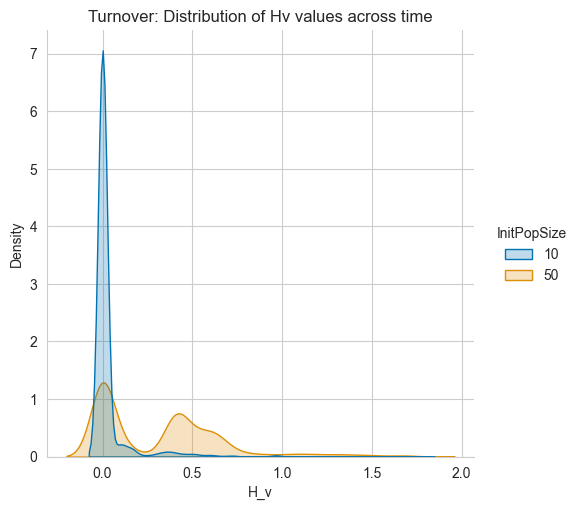

In [51]:
%matplotlib inline

plot_vocab_entropy(regularity_dataframe, "Turnover: Distribution of Hv values across time")

### Plotting the distribution of end-state $H_v$ values only:

Whether the plotting function below shows anything interpretable, depends on how many independent simulation runs you ran. From about >10 runs upwards, it might start showing something interpretable.

In [52]:
regularity_dataframe_end_state_only = regularity_dataframe[regularity_dataframe["Timestep"]==(maxTime-1)]

In [53]:
regularity_dataframe_end_state_only

,Run,Timestep,InitPopSize,H_v,ActiveInfl
1999,0,1999,10,0.000000,1
3999,1,1999,10,0.295839,5
1999,0,1999,50,0.410116,2
3999,1,1999,50,0.000000,1


<Figure size 640x480 with 0 Axes>

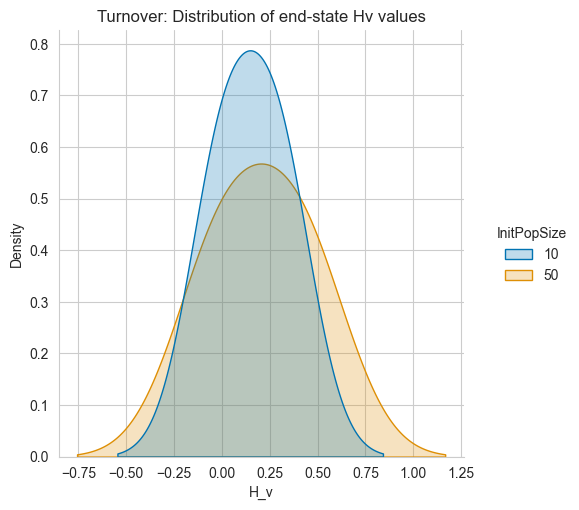

In [54]:
%matplotlib inline

plot_vocab_entropy(regularity_dataframe_end_state_only, "Turnover: Distribution of end-state Hv values")

### Plotting the distribution of $H_v$ values after convergence only:

In [55]:
regularity_dataframe_after_convergence = regularity_dataframe[regularity_dataframe["Timestep"]>=1500]

In [56]:
regularity_dataframe_after_convergence

,Run,Timestep,InitPopSize,H_v,ActiveInfl
1500,0,1500,10,0.0,1
1501,0,1501,10,0.0,1
1502,0,1502,10,0.0,1
1503,0,1503,10,0.0,1
1504,0,1504,10,0.0,1
...,...,...,...,...,...
3995,1,1995,50,0.0,1
3996,1,1996,50,0.0,1
3997,1,1997,50,0.0,1
3998,1,1998,50,0.0,1


<Figure size 640x480 with 0 Axes>

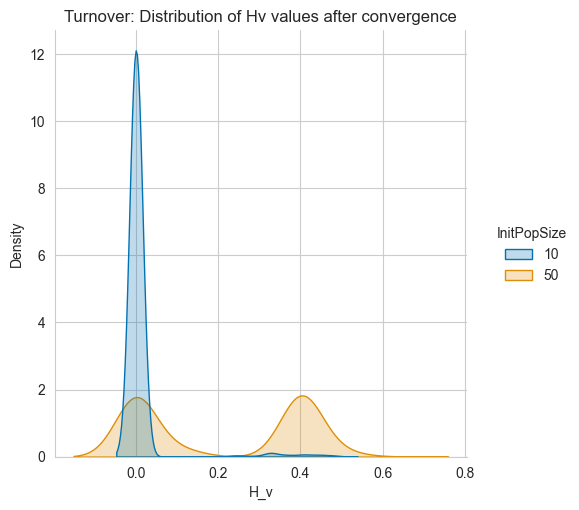

In [57]:
%matplotlib inline

plot_vocab_entropy(regularity_dataframe_after_convergence, "Turnover: Distribution of Hv values after convergence")

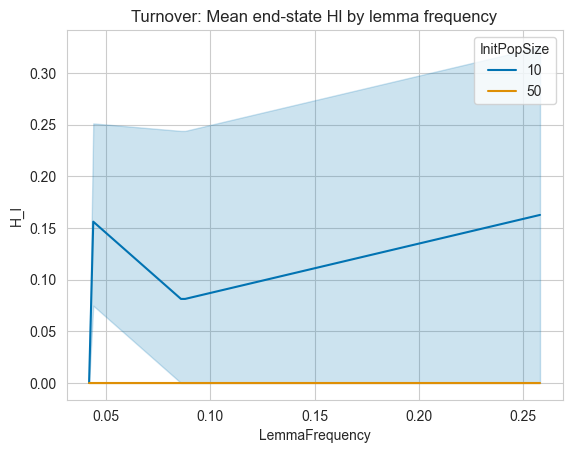

In [58]:
%matplotlib inline

plot_lemma_entropy_by_freq(stability_dataframe, "Turnover: Mean end-state Hl by lemma frequency")

Just FYI: Running the ```plot_active_inflections_over_time()``` function below takes a bit more time than the other two plotting functions.

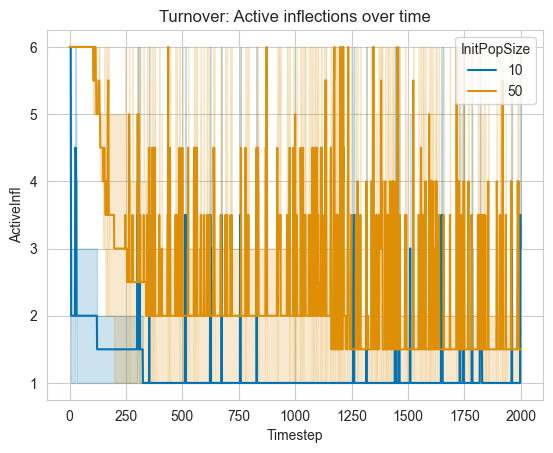

In [59]:
%matplotlib inline

plot_active_inflections_over_time(regularity_dataframe, "Turnover: Active inflections over time")

**Exercise 3:**

**a)** Run a simulation that is similar to the _Turnover_ condition from the Cuskley et al. (2018) paper (section 3.1. _Turnover_; pp. 752-754, and Figure 2), but with smaller populations and fewer lemmas and inflections in the system. Start by using the following parameter settings:

- ```popSizes_to_compare = [10, 50]``` (half of what they used in Cuskley et al., 2018)
- ```runs = 5``` (1/20th of what they used in Cuskley et al., 2018)
- ```maxTime = 2000``` (1/5th of what they used in Cuskley et al., 2018)
- ```k = 750``` (half of what they used in Cuskley et al., 2018)
- ```d = 100``` (same as in Cuskley et al., 2018)
- ```r = 0.001``` (same as in Cuskley et al., 2018)
- ```g = 0.001``` (same as in Cuskley et al., 2018)
- ```lemmas = 14``` (half of what they used in Cuskley et al., 2018)
- ```inflections = 6``` (half of what they used in Cuskley et al., 2018)

How should you set the ```doReplace``` and the ```doGrowth``` parameters in order to reproduce the _Turnover_ condition from Cuskley et al. (2018)?

I've copy-pasted the code cell with the parameter settings below, to make it easy for you to change them without having to scroll all the way back up to the top of the notebook.


**b)** Make plots of your simulation results that are similar to plots (A), (B) and (C) from Figure 2 of the Cuskley et al. (2018) paper. Compare your plots to the corresponding subplots of Figure 2 in the Cuskley et al. (2018) paper, and describe how the results look similar or different. If the pattern of results looks qualitately different for a given subplot, try to explain what could be causing this (i.e., what is different in your simulations compared to those of Cuskley et al., 2018)?


**Answer to exercise 3.a):**

[Your answer should start here, and, depending on the question, may consist of one or more text cells and/or code cells. You can create as many text and/or code cells as you need in order to answer the question.]

In [ ]:
popSizes_to_compare = [10, 50]  # small pop size first, large pop size second. Cuskley et al. (2018) used 20 for small and 100 for large pop
runs = 2  # number of independent simulation runs (int). Cuskley et al. (2018) used 100
maxTime = 2000  # number of timesteps (int). Cuskley et al. (2018) used 10,000
doReplace = True  # whether to do replacement (i.e., population turnover) or not (Boolean; True or False)
doGrowth = False  # whether to do population growth or not (Boolean; True or False)

k = 750  # token threshold for proficiency. Cuskley et al. (2018) used 1500
d = 100  # memory window, see Cuskley et al. (2017): https://doi.org/10.1016/j.cognition.2016.11.001. Cuskley et al. used 100
r = 0.001  # the rate of replacement for turnover. Cuskley et al. (2018) used 0.001.
g = 0.001  # the rate of growth. Cuskley et al. (2018) used 0.001.
lemmas = 14  # number of lemmas (int); 28 in the Cuskley et al. (2018) paper. Cuskley et al. (2018) used 28
inflections = 6  # number of inflections (int); 12 in the Cuskley et al. (2018) paper. Cuskley et al. (2018) used 12

**If you've made a change to the number of lemmas:** Don't forget to also regenerate the topic_list, by simply re-running the code cell below:

In [ ]:
# 2 is what Cuskley et al. (2018) used as the exponent (parameter a) for the Zipfian distribution, and 500 is the
# length of the topic_list from the original code:

topic_list = zipfian_vocab(lemmas, 2, 500)

lemfreq = Counter(topic_list)

**Answer to exercise 3.b):**

[Your answer should start here, and, depending on the question, may consist of one or more text cells and/or code cells. You can create as many text and/or code cells as you need in order to answer the question.]

**Exercise 4:**

**a)** Run a simulation that is similar to the _Growth_ condition from the Cuskley et al. (2018) paper (section 3.2. _Growth_; pp. 754-755, and Figure 3), but with smaller populations and fewer lemmas and inflections in the system. Start by using the following parameter settings (same as for Exercise 3a):

- ```popSizes_to_compare = [10, 50]``` (half of what they used in Cuskley et al., 2018)
- ```runs = 5``` (1/20th of what they used in Cuskley et al., 2018)
- ```maxTime = 2000``` (1/5th of what they used in Cuskley et al., 2018)
- ```k = 750``` (half of what they used in Cuskley et al., 2018)
- ```d = 100``` (same as in Cuskley et al., 2018)
- ```r = 0.001``` (same as in Cuskley et al., 2018)
- ```g = 0.001``` (same as in Cuskley et al., 2018)
- ```lemmas = 14``` (half of what they used in Cuskley et al., 2018)
- ```inflections = 6``` (half of what they used in Cuskley et al., 2018)

How should you set the ```doReplace``` and the ```doGrowth``` parameters in order to reproduce the _Growth_ condition from Cuskley et al. (2018)?


**b)** Make plots of your simulation results that are similar to plots (A), (B) and (C) from Figure 3 of the Cuskley et al. (2018) paper. Compare your plots to the corresponding subplots of Figure 3 in the Cuskley et al. (2018) paper, and describe how the results look similar or different. If the pattern of results looks qualitately different for a given subplot, try to explain what could be causing this (i.e., what is different in your simulations compared to those of Cuskley et al., 2018)?



**Answer to exercise 4.a):**

[Your answer should start here, and, depending on the question, may consist of one or more text cells and/or code cells. You can create as many text and/or code cells as you need in order to answer the question.]

In [ ]:
popSizes_to_compare = [10, 50]  # small pop size first, large pop size second. Cuskley et al. (2018) used 20 for small and 100 for large pop
runs = 2  # number of independent simulation runs (int). Cuskley et al. (2018) used 100
maxTime = 2000  # number of timesteps (int). Cuskley et al. (2018) used 10,000
doReplace = True  # whether to do replacement (i.e., population turnover) or not (Boolean; True or False)
doGrowth = False  # whether to do population growth or not (Boolean; True or False)

k = 750  # token threshold for proficiency. Cuskley et al. (2018) used 1500
d = 100  # memory window, see Cuskley et al. (2017): https://doi.org/10.1016/j.cognition.2016.11.001. Cuskley et al. used 100
r = 0.001  # the rate of replacement for turnover. Cuskley et al. (2018) used 0.001.
g = 0.001  # the rate of growth. Cuskley et al. (2018) used 0.001.
lemmas = 14  # number of lemmas (int); 28 in the Cuskley et al. (2018) paper. Cuskley et al. (2018) used 28
inflections = 6  # number of inflections (int); 12 in the Cuskley et al. (2018) paper. Cuskley et al. (2018) used 12

**Answer to exercise 4.b):**

[Your answer should start here, and, depending on the question, may consist of one or more text cells and/or code cells. You can create as many text and/or code cells as you need in order to answer the question.]

**BONUS Exercise 5:** 

Have a look at the Cuskley et al. (2018) paper: In the growth condition, was there also population turnover (i.e., replacement)? Or did all agents from the initial population stay in the population?

Also describe where in the paper you found the answer to this question, and how you infer your answer from what it says in the paper.

**Answer to BONUS exercise 5:**

[Your answer should start here, and, depending on the question, may consist of one or more text cells and/or code cells. You can create as many text and/or code cells as you need in order to answer the question.]

If you're working in a virtual environment, **don't forget to deactivate your virtual environment** using the ```deactivate``` command.

## References

Cuskley, C., Loreto, V., & Kirby, S. (2018). A Social Approach to Rule Dynamics Using an Agent-Based Model. Topics in Cognitive Science, 10(4), 745–758. https://doi.org/10.1111/tops.12327